In [310]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torch.nn.init as init
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import torch.nn.utils.prune as prune
import seaborn as sns
import math
from torch.utils.tensorboard import SummaryWriter

In [294]:
class myNN(nn.Module):
    def __init__(self):
        super(myNN, self).__init__()
        
        # Input layer (124 neurons)
        self.input_layer = nn.Linear(124,50)  # 124 input neurons, 50 hidden neurons
        self.hidden_layer = nn.Linear(50, 100)# 100 hidden neurons, 3 output neurons
        self.output_layer = nn.Linear(100, 3)
    def forward(self, x):
        x = torch.relu(self.input_layer(x))    # Apply ReLU activation in the input layer
        x = torch.relu(self.hidden_layer(x)) # Apply ReLU activation in the hidden layer
        x = self.output_layer(x)               # Output layer, no activation
        return torch.softmax(x, dim=1)

# Create an instance of the neural network
net = myNN()

# Print the architecture of the network
print(net)

myNN(
  (input_layer): Linear(in_features=124, out_features=50, bias=True)
  (hidden_layer): Linear(in_features=50, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=3, bias=True)
)


In [251]:
data=pd.read_csv('raw_data.csv')
com=pd.read_csv('data.csv')
features=pd.read_csv('features.csv')

In [252]:
mapping={
    'most people':1,
    'many people':0.8,
    'some people':0.6,
    'a few people':0.4,
    'one or two people':0.2,
    'nobody':0,
    'usually': 1,
    'often':0.8,
    'sometimes':0.6,
    'occasionally':0.4,
    'rarely':0.2,
    'never':0,
    'disagree':0,
    'slightly disagree':0.25,
    'neutral':0.5,
    'slightly agree':0.75,
    'agree':1
}

In [253]:
mean=[]
for i in data.index:
    s=0
    c=0
    for column in data.columns[2:]:
        val=data[column][i]
        res = re.sub(' +', ' ',val)
        res=res.lower()
        res=''.join(c for c in res if (c.isalpha()or c==' '))
        res=res.strip()
        if(i>=54 and i<=73 and not pd.isna(val)):
            s=s+(5+int(val))/10
            c=c+1
        elif(res in mapping):
            s=s+mapping[res]
            c=c+1
    if(c==0):
        print(data.loc[i])
    s=s/c
    mean.append(s)

In [254]:
Y=[int(x) for x in list(com['Final Label'])]
num=[0,0,0]
sum=0
for y in Y:
    num[y]=num[y]+1
    s=s+1
for i in range(3):
    num[i]=s/num[i]
class_weights=torch.FloatTensor(num)

In [255]:
def compute_features(df,feature_mapping):
    X=[]
    for column in df.columns[2:]:
        values=list(df[column])
        l=len(values)
        x=[]
        for i in range(l):
            value=values[i]
            res = re.sub(' +', ' ',value)
            res=res.lower()
            res=''.join(y for y in res if (y.isalpha()or y==' '))
            res=res.strip()
            if(i>=54 and i<=73 and not pd.isna(value)): 
                x.append((5+int(value))/10)
            elif(res in feature_mapping):
                x.append(feature_mapping[res])
            else:
                x.append(mean[i])
        X.append(x)
    return X

In [256]:
X=compute_features(data,mapping)

In [300]:
def train(network,path1,path2,X,Y):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
    batch_size = 50
    X_test=torch.from_numpy(np.array(X_test))
    y_test=torch.from_numpy(np.array(y_test))
    torch.save(network.state_dict(), path1)
    initial_weights=[]
    for layer in network.children():
        if isinstance(layer, nn.Linear):
            initial_weights.append(layer.weight.data)
    num_epochs = 100
    X_test=X_test.to(torch.float)
    y_test=y_test.to(torch.long)
    iterations=[]
    losses=[]
    for epoch in range(num_epochs):
        iterations.append(epoch+1)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=epoch)
        l=len(X_train)
        dataset=[]
        for i in range(l):
            dataset.append((np.array(X_train[i]),np.array(y_train[i])))
        train_idxs=[i for i in range(l)]
        train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, train_idxs),batch_size=batch_size, shuffle=True)
        # Forward pass on training data
        for batch in train_loader:
            optimizer.zero_grad()
            x,y=batch
            x=x.float()
            y=y.long()
            y_hat=network(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
#             if ((it + 1) % 1000 == 0 and epoch%100==0):
#                 print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item()}')
        network.eval()
        X_val=torch.from_numpy(np.array(X_val))
        y_val=torch.from_numpy(np.array(y_val))
        X_val=X_val.to(torch.float)
        y_val=y_val.to(torch.long)
        with torch.no_grad():
            outputs = network(X_val)
        loss=criterion(outputs,y_val)
        losses.append(loss)
        if(epoch%10==0):
            print(f'Epoch:{epoch}   Validation Loss:{loss.item()}')
    plt.plot(iterations,losses)
    plt.show()
    # Test
    with torch.no_grad():
        test_outputs = network(X_test)
        predicted_labels = torch.argmax(test_outputs, dim=1)
        accuracy = (predicted_labels == y_test).float().mean()
        print(f'Test Accuracy: {accuracy.item()}')

    print('Training finished!')
    final_weights=[]
    for layer in network.children():
        if isinstance(layer, nn.Linear):
            final_weights.append(layer.weight.data)
    torch.save(network.state_dict(), path2)
    return (initial_weights,final_weights,accuracy)

Epoch:0   Validation Loss:0.9892666339874268
Epoch:100   Validation Loss:0.689551591873169
Epoch:200   Validation Loss:0.700331449508667
Epoch:300   Validation Loss:0.6544123291969299
Epoch:400   Validation Loss:0.6439892649650574
Epoch:500   Validation Loss:0.6412440538406372
Epoch:600   Validation Loss:0.662720799446106
Epoch:700   Validation Loss:0.6067625284194946
Epoch:800   Validation Loss:0.5916774272918701
Epoch:900   Validation Loss:0.6024978160858154


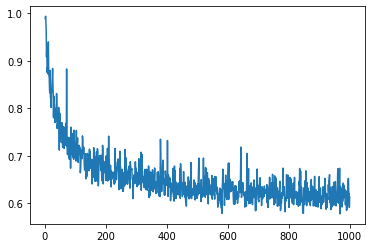

Test Accuracy: 0.6571428775787354
Training finished!


In [296]:
path1="network1_init.pt"
path2="network1_final.pt"
initial_weights,final_weights,accuracy=train(net,path1,path2,X,Y)

In [287]:
def visualize(initial_weights,final_weights):
    l=len(initial_weights)
    for i in range(l):
        sns.heatmap(initial_weights[i])
        plt.show()
        plt.close()
        sns.heatmap(final_weights[i])
        plt.show()
        plt.close()

In [297]:
def pruning(network,path,percentage):
    for module in network.children():  
        prune.l1_unstructured(module, name="weight", amount=percentage)
    masks={}
    for module_name,module in network.named_modules():
        if(module_name!=""):
            for (name,mask) in list(module.named_buffers()):
                key=f"{module_name}.{name}"
                masks[key]=mask
    network.load_state_dict(torch.load(path),strict=False)
    mask_pruner = prune.CustomFromMask(None)
    for module_name, module in network.named_modules():
        key = f"{module_name}.weight_mask"
        if key in masks:
            if isinstance(module, torch.nn.Conv2d):
                _mask = masks[key]
                mask_pruner.apply(module, 'weight', _mask)
            if isinstance(module, torch.nn.Linear):
                _mask = masks[key]
                mask_pruner.apply(module, 'weight', _mask)
        return network

Epoch:0   Validation Loss:0.7289509773254395
Epoch:10   Validation Loss:0.6030286550521851
Epoch:20   Validation Loss:0.6182602047920227
Epoch:30   Validation Loss:0.6228963136672974
Epoch:40   Validation Loss:0.5993136167526245
Epoch:50   Validation Loss:0.6237670183181763
Epoch:60   Validation Loss:0.5896987915039062
Epoch:70   Validation Loss:0.6064648628234863
Epoch:80   Validation Loss:0.6212170124053955
Epoch:90   Validation Loss:0.6027255058288574


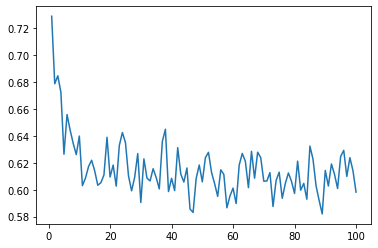

Test Accuracy: 0.7098901271820068
Training finished!
Epoch:0   Validation Loss:0.6955551505088806
Epoch:10   Validation Loss:0.6093762516975403
Epoch:20   Validation Loss:0.6185858845710754
Epoch:30   Validation Loss:0.6123692989349365
Epoch:40   Validation Loss:0.5966735482215881
Epoch:50   Validation Loss:0.6142038106918335
Epoch:60   Validation Loss:0.5920943021774292
Epoch:70   Validation Loss:0.6118699908256531
Epoch:80   Validation Loss:0.622010350227356
Epoch:90   Validation Loss:0.5897504687309265


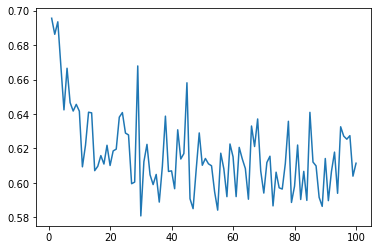

Test Accuracy: 0.7010989189147949
Training finished!
Epoch:0   Validation Loss:0.7128115296363831
Epoch:10   Validation Loss:0.6161802411079407
Epoch:20   Validation Loss:0.6220176219940186
Epoch:30   Validation Loss:0.6234414577484131
Epoch:40   Validation Loss:0.5982272624969482
Epoch:50   Validation Loss:0.6223461627960205
Epoch:60   Validation Loss:0.6154727339744568
Epoch:70   Validation Loss:0.6068449020385742
Epoch:80   Validation Loss:0.6149289011955261
Epoch:90   Validation Loss:0.599698543548584


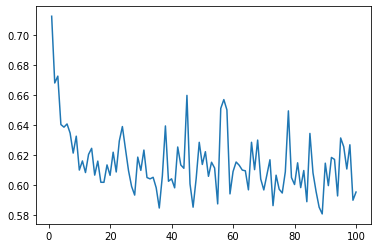

Test Accuracy: 0.7186813354492188
Training finished!
Epoch:0   Validation Loss:0.7136147618293762
Epoch:10   Validation Loss:0.616222620010376
Epoch:20   Validation Loss:0.6275079250335693
Epoch:30   Validation Loss:0.6405177712440491
Epoch:40   Validation Loss:0.6021142601966858
Epoch:50   Validation Loss:0.6169432997703552
Epoch:60   Validation Loss:0.6033682823181152
Epoch:70   Validation Loss:0.6196691989898682
Epoch:80   Validation Loss:0.6149720549583435
Epoch:90   Validation Loss:0.5925753116607666


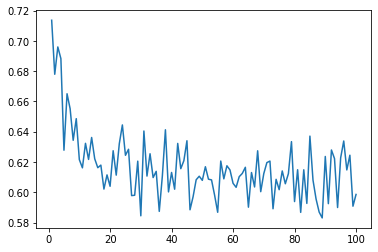

Test Accuracy: 0.7142857313156128
Training finished!
Epoch:0   Validation Loss:0.704303503036499
Epoch:10   Validation Loss:0.5972229838371277
Epoch:20   Validation Loss:0.6201619505882263
Epoch:30   Validation Loss:0.6088845133781433
Epoch:40   Validation Loss:0.6020652055740356
Epoch:50   Validation Loss:0.6150895357131958
Epoch:60   Validation Loss:0.5896234512329102
Epoch:70   Validation Loss:0.6173327565193176
Epoch:80   Validation Loss:0.6142410635948181
Epoch:90   Validation Loss:0.5920332074165344


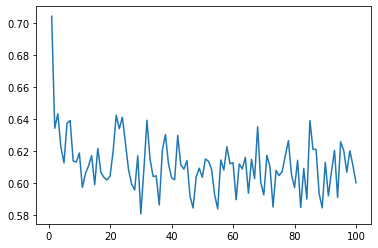

Test Accuracy: 0.7010989189147949
Training finished!
Epoch:0   Validation Loss:0.6868287920951843
Epoch:10   Validation Loss:0.5966375470161438
Epoch:20   Validation Loss:0.6109535098075867
Epoch:30   Validation Loss:0.6146931648254395
Epoch:40   Validation Loss:0.6021260619163513
Epoch:50   Validation Loss:0.6156032681465149
Epoch:60   Validation Loss:0.6005107760429382
Epoch:70   Validation Loss:0.6093746423721313
Epoch:80   Validation Loss:0.6197749972343445
Epoch:90   Validation Loss:0.5912675261497498


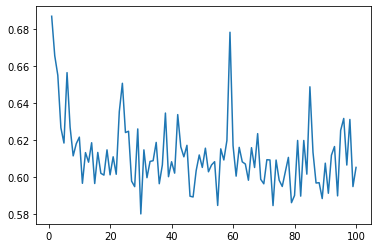

Test Accuracy: 0.7032967209815979
Training finished!
Epoch:0   Validation Loss:0.7287415862083435
Epoch:10   Validation Loss:0.6111500859260559
Epoch:20   Validation Loss:0.6095393300056458
Epoch:30   Validation Loss:0.6060877442359924
Epoch:40   Validation Loss:0.5975370407104492
Epoch:50   Validation Loss:0.6132371425628662
Epoch:60   Validation Loss:0.5870068073272705
Epoch:70   Validation Loss:0.6047453284263611
Epoch:80   Validation Loss:0.6230553984642029
Epoch:90   Validation Loss:0.5941634178161621


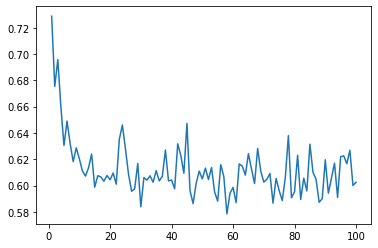

Test Accuracy: 0.7186813354492188
Training finished!
Epoch:0   Validation Loss:0.7010725140571594
Epoch:10   Validation Loss:0.611659824848175
Epoch:20   Validation Loss:0.6272937059402466
Epoch:30   Validation Loss:0.6098505854606628
Epoch:40   Validation Loss:0.60127192735672
Epoch:50   Validation Loss:0.6169582009315491
Epoch:60   Validation Loss:0.6033002138137817
Epoch:70   Validation Loss:0.6124700307846069
Epoch:80   Validation Loss:0.6303648948669434
Epoch:90   Validation Loss:0.5917271375656128


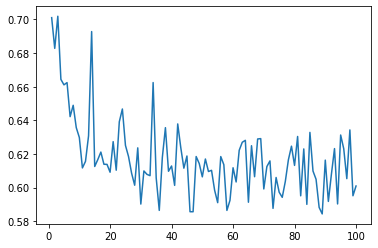

Test Accuracy: 0.7142857313156128
Training finished!
Epoch:0   Validation Loss:0.7015056014060974
Epoch:10   Validation Loss:0.6041088104248047
Epoch:20   Validation Loss:0.6142793893814087
Epoch:30   Validation Loss:0.6077975630760193
Epoch:40   Validation Loss:0.5937231183052063
Epoch:50   Validation Loss:0.6139963269233704
Epoch:60   Validation Loss:0.5931006073951721
Epoch:70   Validation Loss:0.6156848669052124
Epoch:80   Validation Loss:0.6162876486778259
Epoch:90   Validation Loss:0.5901960134506226


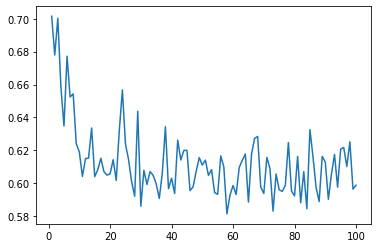

Test Accuracy: 0.7274725437164307
Training finished!
Epoch:0   Validation Loss:0.7039809823036194
Epoch:10   Validation Loss:0.6045226454734802
Epoch:20   Validation Loss:0.6196035146713257
Epoch:30   Validation Loss:0.6080724000930786
Epoch:40   Validation Loss:0.595953106880188
Epoch:50   Validation Loss:0.6152015328407288
Epoch:60   Validation Loss:0.5883750915527344
Epoch:70   Validation Loss:0.6068320870399475
Epoch:80   Validation Loss:0.6131787896156311
Epoch:90   Validation Loss:0.5877097845077515


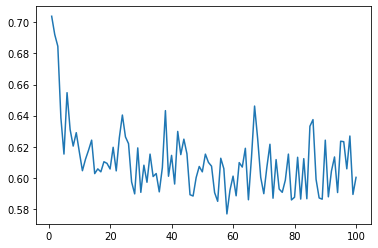

Test Accuracy: 0.7142857313156128
Training finished!
Epoch:0   Validation Loss:0.7253724336624146
Epoch:10   Validation Loss:0.6004519462585449
Epoch:20   Validation Loss:0.615699827671051
Epoch:30   Validation Loss:0.6147279143333435
Epoch:40   Validation Loss:0.5976409912109375
Epoch:50   Validation Loss:0.6205073595046997
Epoch:60   Validation Loss:0.585534393787384
Epoch:70   Validation Loss:0.609886109828949
Epoch:80   Validation Loss:0.6247021555900574
Epoch:90   Validation Loss:0.5885326862335205


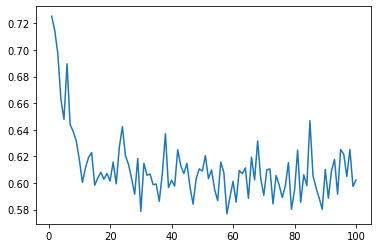

Test Accuracy: 0.7120879292488098
Training finished!
Epoch:0   Validation Loss:0.7671267986297607
Epoch:10   Validation Loss:0.6036228537559509
Epoch:20   Validation Loss:0.6095742583274841
Epoch:30   Validation Loss:0.6174929141998291
Epoch:40   Validation Loss:0.5972514748573303
Epoch:50   Validation Loss:0.615637481212616
Epoch:60   Validation Loss:0.5861846208572388
Epoch:70   Validation Loss:0.6125507354736328
Epoch:80   Validation Loss:0.6269316077232361
Epoch:90   Validation Loss:0.5846560597419739


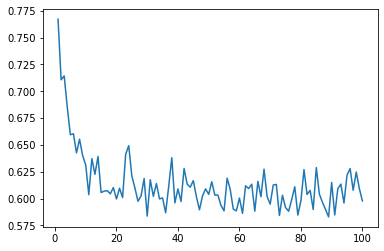

Test Accuracy: 0.7076923251152039
Training finished!
Epoch:0   Validation Loss:0.9948172569274902
Epoch:10   Validation Loss:0.6066201329231262
Epoch:20   Validation Loss:0.6230376362800598
Epoch:30   Validation Loss:0.6169789433479309
Epoch:40   Validation Loss:0.6000679731369019
Epoch:50   Validation Loss:0.6209909319877625
Epoch:60   Validation Loss:0.5911670327186584
Epoch:70   Validation Loss:0.61143958568573
Epoch:80   Validation Loss:0.6175049543380737
Epoch:90   Validation Loss:0.5958524346351624


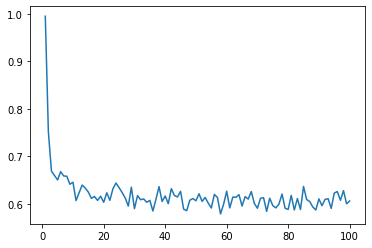

Test Accuracy: 0.7098901271820068
Training finished!
Epoch:0   Validation Loss:0.9767816662788391
Epoch:10   Validation Loss:0.6331360936164856
Epoch:20   Validation Loss:0.6397218108177185
Epoch:30   Validation Loss:0.6361224055290222
Epoch:40   Validation Loss:0.6091359257698059
Epoch:50   Validation Loss:0.6278440356254578
Epoch:60   Validation Loss:0.5936679840087891
Epoch:70   Validation Loss:0.6110895276069641
Epoch:80   Validation Loss:0.6186879277229309
Epoch:90   Validation Loss:0.6020417809486389


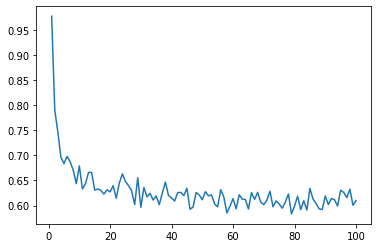

Test Accuracy: 0.696703314781189
Training finished!
Epoch:0   Validation Loss:0.7878706455230713
Epoch:10   Validation Loss:0.6789198517799377
Epoch:20   Validation Loss:0.653652012348175
Epoch:30   Validation Loss:0.6507371664047241
Epoch:40   Validation Loss:0.6350007057189941
Epoch:50   Validation Loss:0.6316872835159302
Epoch:60   Validation Loss:0.6034988164901733
Epoch:70   Validation Loss:0.6410322785377502
Epoch:80   Validation Loss:0.6294305920600891
Epoch:90   Validation Loss:0.6075103878974915


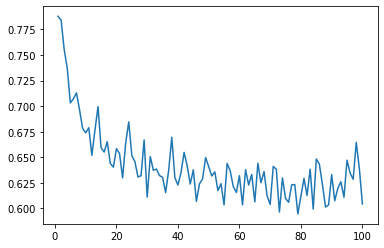

Test Accuracy: 0.69010990858078
Training finished!
Epoch:0   Validation Loss:0.9288225769996643
Epoch:10   Validation Loss:0.7476635575294495
Epoch:20   Validation Loss:0.6870205998420715
Epoch:30   Validation Loss:0.6791627407073975
Epoch:40   Validation Loss:0.6707513332366943
Epoch:50   Validation Loss:0.653548002243042
Epoch:60   Validation Loss:0.6258450746536255
Epoch:70   Validation Loss:0.652133047580719
Epoch:80   Validation Loss:0.656574010848999
Epoch:90   Validation Loss:0.635106086730957


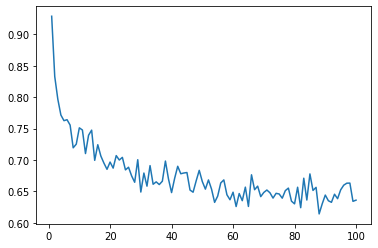

Test Accuracy: 0.6791208982467651
Training finished!
Epoch:0   Validation Loss:0.9614246487617493
Epoch:10   Validation Loss:0.8037214279174805
Epoch:20   Validation Loss:0.769064724445343
Epoch:30   Validation Loss:0.749418318271637
Epoch:40   Validation Loss:0.7338511347770691
Epoch:50   Validation Loss:0.7037488222122192
Epoch:60   Validation Loss:0.6925030946731567
Epoch:70   Validation Loss:0.7317915558815002
Epoch:80   Validation Loss:0.6995280981063843
Epoch:90   Validation Loss:0.6790833473205566


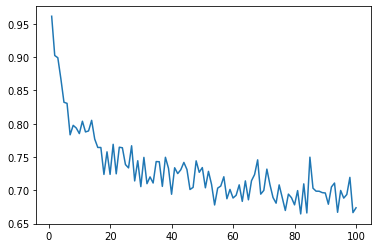

Test Accuracy: 0.6395604610443115
Training finished!
Epoch:0   Validation Loss:1.0626859664916992
Epoch:10   Validation Loss:0.8614487648010254
Epoch:20   Validation Loss:0.8407971262931824
Epoch:30   Validation Loss:0.8200819492340088
Epoch:40   Validation Loss:0.8122263550758362
Epoch:50   Validation Loss:0.7912926077842712
Epoch:60   Validation Loss:0.7520659565925598
Epoch:70   Validation Loss:0.7914107441902161
Epoch:80   Validation Loss:0.7678591012954712
Epoch:90   Validation Loss:0.7550723552703857


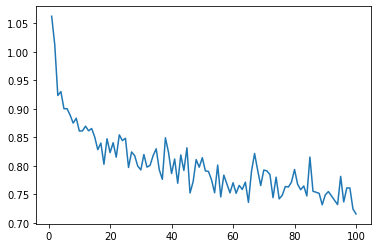

Test Accuracy: 0.5846154093742371
Training finished!
Epoch:0   Validation Loss:1.1180099248886108
Epoch:10   Validation Loss:0.9710441827774048
Epoch:20   Validation Loss:0.9688912630081177
Epoch:30   Validation Loss:0.938603937625885
Epoch:40   Validation Loss:0.9283608794212341
Epoch:50   Validation Loss:0.9247573614120483
Epoch:60   Validation Loss:0.8579280376434326
Epoch:70   Validation Loss:0.9246461391448975
Epoch:80   Validation Loss:0.9063125848770142
Epoch:90   Validation Loss:0.8843480944633484


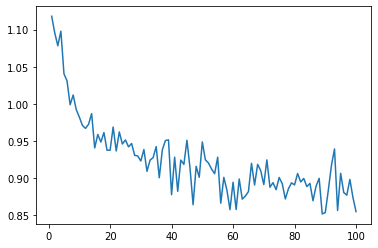

Test Accuracy: 0.4065934121608734
Training finished!


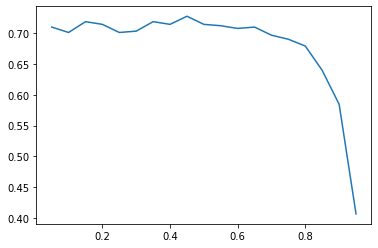

In [301]:
k=0.05
pruned_path1='pruned_init.pt'
pruned_path2='pruned_final.pt'
percentage=[]
accuracy=[]
while(k<1):
    net=myNN()
    net.load_state_dict(torch.load(path2),strict=False)
    newnet=pruning(net,path1,k)
    initial_weights,final_weights,acc=train(newnet,pruned_path1,pruned_path2,X,Y)
    percentage.append(k)
    accuracy.append(acc.item())
    k=k+0.05
plt.plot(percentage,accuracy)
plt.show()

In [303]:
net=myNN()
net.load_state_dict(torch.load(path2),strict=False)

<All keys matched successfully>

In [313]:
inputX=torch.randn(1,124)
writer = SummaryWriter("torchlogs/")
writer.add_graph(net, inputX)
writer.close()